## Bibliotecas

In [1]:
using LinearAlgebra
using Plots
using GaussQuadrature
using SparseArrays
using DataFrames

# Definições iniciais

## Definição das f's das equações e suas soluções analíticas 

In [2]:
function f1(x::Float64, α::Float64, β::Float64)
    return -2*α + β*(x^2-x)
end

function u1(x::Float64)
    return x*(x-1)
end

function f2(x::Float64, α::Float64, β::Float64)
    return (α*π^2 + β)*sin(π*x)
end

function u2(x::Float64)
    return sin(π*x)
end

function f3(x::Float64, α::Float64, β::Float64)
    return 8.0::Float64
end

function u3(x::Float64)
    return -4*x*(x-1)::Float64
end

function f4(x::Float64, α::Float64, β::Float64)
    return x::Float64
end

function u4(x::Float64)
    return x + (exp(-x) - exp(x))/(exp(1) - exp(-1)) ::Float64
end

u4 (generic function with 1 method)

## Base

In [3]:
function ϕ₁(ξ)
    return (1.0 - ξ)/2.0 :: Float64
end

function ϕ₂(ξ)
    return (1.0 + ξ)/2.0 :: Float64
end

function dϕ₁(ξ)
    return -1.0/2.0 :: Float64
end

function dϕ₂(ξ)
    return 1.0/2.0 :: Float64
end

dϕ₂ (generic function with 1 method)

## Funções auxiliares de cálculo

In [4]:
function get_point(index::Int64, m::Int64)
    return convert(Float64, index/(m+1))     
end

function map_ξ_x(ξ, x_i_inf, h)
    return x_i_inf + ((h*(ξ+1))/2.0)
end

function quadratura_F_local(f, ϕ, α, β, e, m)
    pontos, pesos = legendre(5)
    quad = 0
    
    h = 1/(m+1)
    x_i_inf = get_point(e-1, m)
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f(map_ξ_x(ξ, x_i_inf, h), α, β) * ϕ(ξ)) 
    end
    
    return quad
end
    

function quadratura_phis_K(f1, f2)
    pontos, pesos = legendre(5)
    quad = 0
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f1(ξ) * f2(ξ) ) 
    end
    
    return quad
end

quadratura_phis_K (generic function with 1 method)

## Funções auxiliares de visualização

In [5]:
function plot_exact_and_numerical(ne::Int64, f_exact, sol_on_points, isContinous::Bool)
    m = ne-1
    points = get_point.(0:ne, m)
    plot(f_exact, range(0, 1, 100), lw=3, label="Solução Exata")

    if(isContinous)
        display(plot!(points, sol_on_points, lw=3, markershape=:circle, label="Solução Numérica"))
    else 
        display(plot!(points, sol_on_points, lw=3, seriestype=:scatter, label="Solução Numérica"))
    end

end

function plot_exact_and_numerical(ne::Int64, u, t, α, β, sol_on_points, isContinous::Bool)
    m = ne-1
    points = get_point.(0:ne, m)
    
    u_on_points = u.((range(0, 1, 100), t, α, β)...)
    
    plot(range(0, 1, 100), u_on_points, lw=3, label="Solução Exata")

    if(isContinous)    
        display(plot!(points, sol_on_points, lw=3, markershape=:circle, label="Solução Numérica"))
    else     
        display(plot!(points, sol_on_points, lw=3, seriestype=:scatter, label="Solução Numérica"))
    end
end

function plot_exact_and_numerical(ne::Int64, u, t, α, β, γ, sol_on_points, isContinous::Bool)
    m = ne-1
    points = get_point.(0:ne, m)
    
    u_on_points = u.((range(0, 1, 100), t, α, β, γ)...)
    
    plot(range(0, 1, 100), u_on_points, lw=3, label="Solução Exata")

    if(isContinous)    
        display(plot!(points, sol_on_points, lw=3, markershape=:circle, label="Solução Numérica"))
    else     
        display(plot!(points, sol_on_points, lw=3, seriestype=:scatter, label="Solução Numérica"))
    end
end

plot_exact_and_numerical (generic function with 3 methods)

## Funções principais de resolução

In [6]:
function monta_LG(ne)
    return transpose(hcat(1:ne, 2:ne+1))
end

function monta_EQ(ne)
    m = ne-1
    return vcat(m+1, 1:m, m+1)
end

function monta_F_local(f, α, β, m, e)
    h = 1/(m+1)
    
    F_local = zeros(2)
    F_local[1] = h/2 * quadratura_F_local(f, ϕ₁, α, β, e, m)
    F_local[2] = h/2 * quadratura_F_local(f, ϕ₂, α, β, e, m)

    return F_local    
end

function monta_K_local(α, β, m)
    h = 1/(m+1)
    K_local = zeros(2, 2)
    
    K_local[1, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₁)
    K_local[1, 2] = K_local[2, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₂)
    K_local[2, 2] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₂)    
    
    return K_local
end

function monta_F_global(f, α, β, ne, EQoLG)
    m = ne-1
    F_global = zeros(m+1)

    for e in 1:m+1
        F_local = monta_F_local(f, α, β, m, e)
        for i in 1:2
            index = EQoLG[i, e]
            F_global[index] += F_local[i]
        end
    end
    
    return F_global[1:m]
end

function monta_K_global(α, β, ne, EQoLG)
    m = ne-1
    K_global = spzeros(m+1,m+1)
    K_local = monta_K_local(α, β, m)
    
    for e in 1:m+1
        for i in 1:2
            for j in 1:2
                i_global = EQoLG[i, e]
                j_global = EQoLG[j, e]
                
                K_global[i_global, j_global] += K_local[i, j]
            end
        end
    end
    
    
    return K_global[1:m, 1:m]
    
end

function monta_uh(c)    
    return vcat(0, c, 0)
end

monta_uh (generic function with 1 method)

## Cálculo do Erro

In [7]:
function erro_L2(u, c̄, ne)
    m = ne-1
    h = 1/(m+1)
    
    pontos, pesos = legendre(5)
    erro_quadrado = 0

    for e in 1:ne
        x_i_inf = get_point(e-1, m)

        for (ξ, W) in zip(pontos, pesos)
            erro_quadrado += W * (u(map_ξ_x(ξ, x_i_inf, h)) - c̄[e]*ϕ₁(ξ) - c̄[e+1]*ϕ₂(ξ))^2 
        end
    end
    
    return sqrt(erro_quadrado * h/2)    
end

erro_L2 (generic function with 1 method)

In [8]:
function erro_L2_parabolico(u, α, β, c̄, ne)
    m = ne-1
    h = 1/(m+1)
    
    pontos, pesos = legendre(5)
    erro_quadrado = 0

    for e in 1:ne
        x_i_inf = get_point(e-1, m)

        for (ξ, W) in zip(pontos, pesos)
            erro_quadrado += W * (u(map_ξ_x(ξ, x_i_inf, h), α, β) - c̄[e]*ϕ₁(ξ) - c̄[e+1]*ϕ₂(ξ))^2 
        end
    end
    
    return sqrt(erro_quadrado * h/2)    
end

function erro_L2_parabolico_2(u, α, β, γ, c̄, ne)
    m = ne-1
    h = 1/ne
    
    pontos, pesos = legendre(5)
    erro_quadrado = 0

    for e in 1:ne
        x_i_inf = get_point(e-1, m)

        for (ξ, W) in zip(pontos, pesos)
            erro_quadrado += W * (u(map_ξ_x(ξ, x_i_inf, h), α, β, γ) - c̄[e]*ϕ₁(ξ) - c̄[e+1]*ϕ₂(ξ))^2 
        end
    end
    
    return sqrt(erro_quadrado * h/2)    
end

erro_L2_parabolico_2 (generic function with 1 method)

## Estudo de Convergência

In [9]:
function estudo_convergencia(n_testes, f, u, α, β)
    ne_list = 2 .^ (2:n_testes) 
    h_list = []
    erros = []
    
    for ne in ne_list
        m = ne-1
        h = 1/(m+1)
        
        LG = monta_LG(ne)
        EQ = monta_EQ(ne)
        EQoLG = EQ[LG]
        
        K = monta_K_global(α, β, ne, EQoLG)
        F = monta_F_global(f, α, β, ne, EQoLG)

        c = K\F
        uh = monta_uh(c)
        
        erro = erro_L2(u, uh, ne)
        push!(erros, erro)
        push!(h_list, h)        
    end

    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    display(plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft))
end

estudo_convergencia (generic function with 1 method)

# Exemplos

In [10]:
function solucao_e_teste(α, β, f, u, ne, n_testes)
    LG = monta_LG(ne)
    EQ = monta_EQ(ne)

    EQoLG = EQ[LG]

    K = monta_K_global(α, β, ne, EQoLG)
    F = monta_F_global(f, α, β, ne, EQoLG)

    c = K\F
    uh = monta_uh(c)

    plot_exact_and_numerical(ne, u, uh, true)
    estudo_convergencia(n_testes, f, u, α, β)
    
    return
end

solucao_e_teste (generic function with 1 method)

## Caso 1

In [11]:
α = 1.0
β = 1.0
f = f1
u = u1
ne = 4
n_testes = 17

#@time solucao_e_teste(α, β, f, u, ne, n_testes)

17

## Caso 2

In [12]:
α = 1.0
β = 1.0
f = f2
u = u2
ne = 4
n_testes = 17

#@time solucao_e_teste(α, β, f, u, ne, n_testes)

17

## Caso 3

In [13]:
α = 1.0
β = 0.0
f = f3
u = u3
ne = 4
n_testes = 17

#@time solucao_e_teste(α, β, f, u, ne, n_testes)

17

## Caso 4

In [14]:
α = 1.0
β = 1.0
f = f4
u = u4
ne = 4
n_testes = 17

#@time solucao_e_teste(α, β, f, u, ne, n_testes)

17

# Nova equação

## Formulação forte

$-α u''(x) + β u(x) + γ u'(x) = f(x); x ∈ ]0, 1[$

$u(0) = u(1) = 0$

### Desenvolvimento: Formulação fraca

$-α u''(x) v(x) + β u(x) v(x) + γ u'(x) v(x) = f(x) v(x)$

$-α \int_{0}^{1} u'' v dx + β \int_{0}^{1} u v dx + γ \int_{0}^{1} u' v dx = \int_{0}^{1} f v dx$

$α \int_{0}^{1} u' v' dx + β \int_{0}^{1} u v dx + γ \int_{0}^{1} u' v dx = \int_{0}^{1} f v dx$

## Formulação fraca

$α \int_{0}^{1} u' v' dx + β \int_{0}^{1} u v dx + γ \int_{0}^{1} u' v dx = \int_{0}^{1} f v dx$

$u, v \in V$

## Problema aproximado: Galerkin

$α \int_{0}^{1} u'^{h} v'^{h} dx + β \int_{0}^{1} u^{h} v^{h} dx + γ \int_{0}^{1} u'^{h} v^{h} dx = \int_{0}^{1} f v^{h} dx$

$u^{h}, v^{h} \in V^{h}$

### Desenvolvimento: Forma matriz-vetor

$α \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) v'^{h} dx + β \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi_j) v^{h} dx + γ \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) v^{h} dx = \int_{0}^{1} f v^{h} dx$

$v^h = \varphi_i \forall i \in \{1, 2, ..., m\} $

$α \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) \varphi'_i dx + β \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi_j) \varphi_i dx + γ \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) \varphi_i dx = \int_{0}^{1} f \varphi_i dx$

$ \sum_{j=1}^{m} c_j α \int_{0}^{1} \varphi'_j \varphi'_i dx + \sum_{j=1}^{m} c_j β \int_{0}^{1} \varphi_j \varphi_i dx + \sum_{j=1}^{m} c_j γ \int_{0}^{1} \varphi'_j \varphi_i dx = \int_{0}^{1} f \varphi_i dx$

$ \sum_{j=1}^{m} c_j (α \int_{0}^{1} \varphi'_j \varphi'_i dx + β \int_{0}^{1} \varphi_j \varphi_i dx + γ \int_{0}^{1} \varphi'_j \varphi_i dx)  = \int_{0}^{1} f \varphi_i dx$

$K_{i, j} = α \int_{0}^{1} \varphi'_j \varphi'_i dx + β \int_{0}^{1} \varphi_j \varphi_i dx + γ \int_{0}^{1} \varphi'_j \varphi_i dx$

$c = [c_1, c_2, ...,  c_m]^T$

$F_{i} = \int_{0}^{1} f \varphi_i dx$

## Forma matriz-vetor

$K_{m \times m} c_{m \times 1} = F_{m \times 1}$

$K_{i, j} = α \int_{0}^{1} \varphi'_j \varphi'_i dx + β \int_{0}^{1} \varphi_j \varphi_i dx + γ \int_{0}^{1} \varphi'_j \varphi_i dx$

$c = [c_1, c_2, ...,  c_m]^T$

$F_{i} = \int_{0}^{1} f \varphi_i dx$

### Desenvolvimento: Montagem das estruturas locais

## Estruturas Locais

## Funções Auxiliares

In [15]:
function quadratura_F_local_2(f, ϕ, α, β, γ, e, m)
    pontos, pesos = legendre(5)
    quad = 0
    
    h = 1/(m+1)
    x_i_inf = get_point(e-1, m)
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f(map_ξ_x(ξ, x_i_inf, h), α, β, γ) * ϕ(ξ)) 
    end
    
    return quad
end

quadratura_F_local_2 (generic function with 1 method)

## Funções Principais

In [16]:
function monta_F_local_2(f, α, β, γ, m, e)
    h = 1/(m+1)
    
    F_local = zeros(2)
    F_local[1] = h/2 * quadratura_F_local_2(f, ϕ₁, α, β, γ, e, m)
    F_local[2] = h/2 * quadratura_F_local_2(f, ϕ₂, α, β, γ, e, m)

    return F_local    
end

function monta_K_local_2(α, β, γ, m)
    h = 1/(m+1)
    K_local = zeros(2, 2)
    
    K_local[1, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₁) + γ * quadratura_phis_K(ϕ₁, dϕ₁)
    K_local[1, 2] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₂) + γ * quadratura_phis_K(ϕ₁, dϕ₂)
    K_local[2, 1] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₁) + γ * quadratura_phis_K(ϕ₂, dϕ₁)
    K_local[2, 2] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₂) + γ * quadratura_phis_K(ϕ₂, dϕ₂)   
    
    return K_local
end

function monta_F_global_2(f, α, β, γ, ne, EQoLG)
    m = ne-1
    F_global = zeros(m+1)

    for e in 1:m+1
        F_local = monta_F_local_2(f, α, β, γ, m, e)
        for i in 1:2
            index = EQoLG[i, e]
            F_global[index] += F_local[i]
        end
    end
    
    return F_global[1:m]
end

function monta_K_global_2(α, β, γ, ne, EQoLG)
    m = ne-1
    K_global = spzeros(m+1,m+1)
    K_local = monta_K_local_2(α, β, γ, m)
    
    for e in 1:m+1
        for i in 1:2
            for j in 1:2
                i_global = EQoLG[i, e]
                j_global = EQoLG[j, e]
                
                K_global[i_global, j_global] += K_local[i, j]
            end
        end
    end
    
    
    return K_global[1:m, 1:m]
    
end

monta_K_global_2 (generic function with 1 method)

## Funções pra checagem de compatibilidade/corretude

In [17]:
function f3_γ(x::Float64, α::Float64, β::Float64, γ::Float64)
    return 8.0::Float64
end

function f4_γ(x::Float64, α::Float64, β::Float64, γ::Float64)
    return x::Float64
end

function estudo_convergencia_2(n_testes, f, u, α, β, γ)
    ne_list = 2 .^ (2:n_testes) 
    h_list = []
    erros = []
    
    for ne in ne_list
        m = ne-1
        h = 1/(m+1)
        
        LG = monta_LG(ne)
        EQ = monta_EQ(ne)
        EQoLG = EQ[LG]
        
        K = monta_K_global_2(α, β, γ, ne, EQoLG)
        F = monta_F_global_2(f, α, β, γ, ne, EQoLG)

        c = K\F
        uh = monta_uh(c)
        
        erro = erro_L2(u, uh, ne)
        push!(erros, erro)
        push!(h_list, h)        
    end

    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    display(plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft))
end

function solucao_e_teste_2(α, β, γ, f, u, ne, n_testes)
    LG = monta_LG(ne)
    EQ = monta_EQ(ne)

    EQoLG = EQ[LG]

    K = monta_K_global_2(α, β, γ, ne, EQoLG)
    F = monta_F_global_2(f, α, β, γ, ne, EQoLG)

    c = K\F
    uh = monta_uh(c)

    plot_exact_and_numerical(ne, u, uh, true)
    estudo_convergencia_2(n_testes, f, u, α, β, γ)
    
    return
end

solucao_e_teste_2 (generic function with 1 method)

## Checagem

In [18]:
α = 1.0
β = 0.0
γ = 0.0
f = f3_γ
u = u3
ne = 4
n_testes = 17

#@time solucao_e_teste_2(α, β, γ, f, u, ne, n_testes)

17

In [19]:
α = 1.0
β = 1.0
γ = 0.0
f = f4_γ
u = u4
ne = 4
n_testes = 17

#@time solucao_e_teste_2(α, β, γ, f, u, ne, n_testes)

17

# Versão com o tempo

## Funções

In [20]:
function f1_parabolica(x, t, α, β)
    return 0
end

function u1_parabolica(x, t, α, β)
    λ = α*π^2 + β
    return (1/(π^2)) * sin(π*x) * ℯ^(-λ*t)
end

function f2_parabolica(x, t, α, β)
    λ = 1
    return ((-λ + α*π^2 + β)/(π^2))*sin(π*x)*ℯ^(-λ*t)
end

function u2_parabolica(x, t, α, β)
    λ = 1
    return (1/(π^2)) * sin(π*x) * ℯ^(-λ*t)
end

u2_parabolica (generic function with 1 method)

In [21]:
function solucao_e_teste_parabolico(α, β, T, N, f, u, u_0, tipo_u0h, ne)
    m = ne-1
    
    LG = monta_LG(ne)
    EQ = monta_EQ(ne)

    EQoLG = EQ[LG]

    M = monta_K_global(0, 1, ne, EQoLG)
    K = monta_K_global(α, β, ne, EQoLG)
    
    τ = T/N
    t = 0:τ:T
    
    #caso inicial
    Cⁿ = zeros(m, 1)
    
    if(tipo_u0h == 1)
        Cⁿ_1 = u_0.(get_point.(1:m, m))
    end
    #elseif(tipo_u0h == 2)
    #    Cⁿ_1 = 
    
    A = M + (τ/2)*K
    B = M - (τ/2)*K
    
    #display(ne)
    #display(EQoLG)
    #display(M)
    #display(K)
    #display(A)
    #display(B)    
   
    erros_iteracoes = []
    display(plot_exact_and_numerical(ne, u, t[1], α, β, monta_uh(Cⁿ_1), true))
    push!(erros_iteracoes, erro_L2_parabolico((x, α, β) -> u(x, t[1], α, β), α, β, monta_uh(Cⁿ_1), ne))
    for n in 1:N
        
        #display("Cn-1")
        #display(Cⁿ_1)
        #display("t_medio")
        #display((t[n]+t[n+1])/2)
        Fⁿ_meio = monta_F_global((x, α, β) -> f(x, (t[n]+t[n+1])/2, α, β), α, β, ne, EQoLG)
        #display("Fn_meio")
        #display(Fⁿ_meio)
        
        Cⁿ = A \ ( B * Cⁿ_1 + τ * Fⁿ_meio)
        #display("Cn")
        #display(Cⁿ)        
        uh = monta_uh(Cⁿ)        
        
        #display("uh:")
        #display(uh)
        #display(plot_exact_and_numerical(ne, u, t[n+1], α, β, uh, true))
        
        Cⁿ_1 = Cⁿ
        erro = erro_L2_parabolico((x, α, β) -> u(x, t[n+1], α, β), α, β, uh, ne)
        push!(erros_iteracoes, erro)
    end
    
    #display("Erros L2")
    #display(erros_iteracoes)
    #display("Máximo erro L2")
    #display(maximum(erros_iteracoes))    
    return
end

solucao_e_teste_parabolico (generic function with 1 method)

In [22]:
u0(x) = sin(π*x)/π^2

#solucao_e_teste_parabolico(1, 1, 1, 8, f2_parabolica, u2_parabolica, u0, 1, 8)

u0 (generic function with 1 method)

In [23]:
function estudo_convergencia_parabolico(α, β, T, f, u, u_0, n_testes)
    ne_list = 2 .^ (2:n_testes) 
    h_list = []
    erros = []
    
    for ne in ne_list
        m = ne-1
        N = ne
        h = 1/ne
        push!(h_list, h)
    
        LG = monta_LG(ne)
        EQ = monta_EQ(ne)

        EQoLG = EQ[LG]

        M = monta_K_global(0, 1, ne, EQoLG)
        K = monta_K_global(α, β, ne, EQoLG)

        τ = T/N
        t = 0:τ:T

        #caso inicial
        Cⁿ = zeros(m, 1)
        Cⁿ_1 = u_0.(get_point.(1:m, m))

        A = M + (τ/2)*K
        B = M - (τ/2)*K  

        erros_iteracoes = []
        push!(erros_iteracoes, erro_L2_parabolico((x, α, β) -> u(x, t[1], α, β), α, β, monta_uh(Cⁿ_1), ne))

        for n in 1:N

            Fⁿ_meio = monta_F_global((x, α, β) -> f(x, (t[n]+t[n+1])/2, α, β), α, β, ne, EQoLG)
            Cⁿ = A \ ( B * Cⁿ_1 + τ * Fⁿ_meio)
            uh = monta_uh(Cⁿ)
            Cⁿ_1 = Cⁿ

            erro = erro_L2_parabolico((x, α, β) -> u(x, t[n+1], α, β), α, β, uh, ne)
            push!(erros_iteracoes, erro)
        end

        push!(erros, maximum(erros_iteracoes))
    end
    
    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    display(plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft))
    display(DataFrame(h=h_list, erro=erros))
end

estudo_convergencia_parabolico (generic function with 1 method)

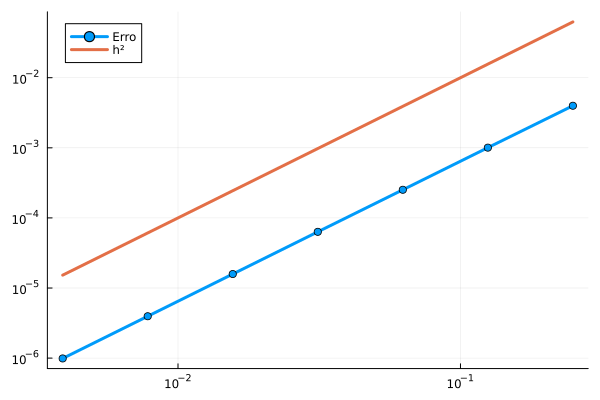

Row,h,erro
,Any,Any
1,0.25,0.00398034
2,0.125,0.0010052
3,0.0625,0.000251949
4,0.03125,6.33036e-5
5,0.015625,1.58247e-5
6,0.0078125,3.9563e-6
7,0.00390625,9.89128e-7


In [24]:
estudo_convergencia_parabolico(1, 1, 1, f2_parabolica, u2_parabolica, u0, 8)

## Incluindo não linearidade

In [25]:
function quadratura_G_local(e, _c, g, α, β, γ, EQoLG, ne, ϕ)
    pontos, pesos = legendre(5)
    quad = 0
    
    h = 1/ne
    x_i_inf = get_point(e-1, ne-1)
    
    for (ξ, W) in zip(pontos, pesos)
         x_ξ = map_ξ_x(ξ, x_i_inf, h), α, β, γ
         quad += W*( g(_c[EQoLG[1, e]] * ϕ₁(ξ) + _c[EQoLG[2, e]] * ϕ₂(ξ))  * ϕ(ξ)) 
    end
    
    return quad
end

function monta_G_local(e, _c, g, α, β, γ, EQoLG, ne)
    h = 1/ne
    
    G_local = zeros(2)
    G_local[1] = h/2 * quadratura_G_local(e, _c, g, α, β, γ, EQoLG, ne, ϕ₁)
    G_local[2] = h/2 * quadratura_G_local(e, _c, g, α, β, γ, EQoLG, ne, ϕ₂)
    
    return G_local
    
end

function monta_G_global(_c, g, α, β, γ, EQoLG, ne, m)
    G_global = zeros(m+1)
    
    for e in 1:ne
        G_local = monta_G_local(e, _c, g, α, β, γ, EQoLG, ne)
        for i in 1:2
            index = EQoLG[i, e]
            G_global[index] += G_local[i]
        end
    end
    
    return G_global[1:m]
end

monta_G_global (generic function with 1 method)

In [26]:
function solucao_e_teste_parabolico_naolinear(α, β, γ, g, T, f, u, u_0, tipo_u0h, ne)
    m = ne-1
    N = ne
    
    LG = monta_LG(ne)
    EQ = monta_EQ(ne)

    EQoLG = EQ[LG]

    M = monta_K_global_2(0, 1, 0, ne, EQoLG)
    K = monta_K_global_2(α, β, γ, ne, EQoLG)
    
    τ = T/N
    t = 0:τ:T
    
    #caso inicial
    Cⁿ = zeros(m, 1)
    Cⁿ_1 = zeros(m, 1)
    
    if(tipo_u0h == 1)
        Cⁿ_1 = u_0.(get_point.(1:m, m))
    end
    #elseif(tipo_u0h == 2)
    #    Cⁿ_1 = 
    
    A = M + (τ/2)*K
    B = M - (τ/2)*K
    
    #t1 predição

    G = monta_G_global([Cⁿ_1; 0], g, α, β, γ, EQoLG, ne, m)
    Fⁿ_meio = monta_F_global_2((x, α, β, γ) -> f(x, (t[1]+t[2])/2, α, β, γ), α, β, γ, ne, EQoLG)

    Cⁿ = A \ (B * Cⁿ_1 - τ * G + τ * Fⁿ_meio)

    #t1 correção

    c = 1/2 * (Cⁿ + Cⁿ_1)
    G = monta_G_global([c;0], g, α, β, γ, EQoLG, ne, m)

    Cⁿ = A \ (B * Cⁿ_1 - τ * G + τ * Fⁿ_meio)

    erros_iteracoes = []
    push!(erros_iteracoes, erro_L2_parabolico_2((x, α, β, γ) -> u(x, t[1], α, β, γ), α, β, γ, monta_uh(Cⁿ_1), ne))

    Cⁿ_2 = Cⁿ_1
    Cⁿ_1 = Cⁿ
    
    #display(ne)
    #display(EQoLG)
    #display(M)
    #display(K)
    #display(A)
    #display(B)
    
    for n in 2:N
        
        c = (3*Cⁿ_1 - Cⁿ_2)/2    
        G = monta_G_global([c;0], g, α, β, γ, EQoLG, ne, m)

        #display("Cn-1")
        #display(Cⁿ_1)
        #display("t_medio")
        #display((t[n]+t[n+1])/2)
        
        Fⁿ_meio = monta_F_global_2((x, α, β, γ) -> f(x, (t[n]+t[n+1])/2, α, β, γ), α, β, γ, ne, EQoLG)
        
        #display("Fn_meio")
        #display(Fⁿ_meio)
        
        Cⁿ = A \ ( B * Cⁿ_1 - τ * G + τ * Fⁿ_meio)
        
        #display("Cn")
        #display(Cⁿ)  
        
        uh = monta_uh(Cⁿ)
        Cⁿ_2 = Cⁿ_1
        Cⁿ_1 = Cⁿ
        
        #display("uh:")
        #display(uh)
        display(plot_exact_and_numerical(ne, u, t[n+1], α, β, γ, uh, true))

        erro = erro_L2_parabolico_2((x, α, β, γ) -> u(x, t[n+1], α, β, γ), α, β, γ, uh, ne)
        push!(erros_iteracoes, erro)
    end
    
    display("Erros L2")
    display(erros_iteracoes)
    display("Máximo erro L2")
    display(maximum(erros_iteracoes))
    return
end

solucao_e_teste_parabolico_naolinear (generic function with 1 method)

In [27]:
function estudo_convergencia_parabolico_naolinear(α, β, γ, g, T, f, u, u_0, n_testes)
    ne_list = 2 .^ (2:n_testes) 
    h_list = []
    erros = []
    
    for ne in ne_list
        m = ne-1
        N = ne
        h = 1/ne
        push!(h_list, h)
    
        LG = monta_LG(ne)
        EQ = monta_EQ(ne)

        EQoLG = EQ[LG]

        M = monta_K_global_2(0, 1, 0, ne, EQoLG)
        K = monta_K_global_2(α, β, γ, ne, EQoLG)

        τ = T/N
        t = 0:τ:T

        #caso inicial
        Cⁿ = zeros(m, 1)
        Cⁿ_1 = u_0.(get_point.(1:m, m))

        A = M + (τ/2)*K
        B = M - (τ/2)*K  

        #t1 predição

        G = monta_G_global([Cⁿ_1; 0], g, α, β, γ, EQoLG, ne, m)
        Fⁿ_meio = monta_F_global_2((x, α, β, γ) -> f(x, (t[1]+t[2])/2, α, β, γ), α, β, γ, ne, EQoLG)
        
        Cⁿ = A \ (B * Cⁿ_1 - τ * G + τ * Fⁿ_meio)

        #t1 correção

        c = 1/2 * (Cⁿ + Cⁿ_1)
        G = monta_G_global([c;0], g, α, β, γ, EQoLG, ne, m)

        Cⁿ = A \ (B * Cⁿ_1 - τ * G + τ * Fⁿ_meio)

        erros_iteracoes = []
        push!(erros_iteracoes, erro_L2_parabolico_2((x, α, β, γ) -> u(x, t[1], α, β, γ), α, β, γ, monta_uh(Cⁿ_1), ne))

        Cⁿ_2 = Cⁿ_1
        Cⁿ_1 = Cⁿ
        for n in 2:N
            
            c = (3*Cⁿ_1 - Cⁿ_2)/2    
            G = monta_G_global([c;0], g, α, β, γ, EQoLG, ne, m)
            
            Fⁿ_meio = monta_F_global_2((x, α, β, γ) -> f(x, (t[n]+t[n+1])/2, α, β, γ), α, β, γ, ne, EQoLG)
            Cⁿ = A \ ( B * Cⁿ_1 - τ * G + τ * Fⁿ_meio)
            uh = monta_uh(Cⁿ)
            Cⁿ_2 = Cⁿ_1
            Cⁿ_1 = Cⁿ

            erro = erro_L2_parabolico_2((x, α, β, γ) -> u(x, t[n+1], α, β, γ), α, β, γ, uh, ne)
            push!(erros_iteracoes, erro)
        end

        push!(erros, maximum(erros_iteracoes))
    end
    
    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    display(plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft))
    display(DataFrame(h=h_list, erro=erros))
end

estudo_convergencia_parabolico_naolinear (generic function with 1 method)

In [28]:
function f2_parabolica_naolinear(x, t, α, β, γ, g, u)
    λ = 1
    return sin(π*x)*ℯ^(-λ*t) + g(u(x, t, α, β, γ))
end

function u2_parabolica_naolinear(x, t, α, β, γ)
    λ = 1
    return (1/(π^2)) * sin(π*x) * ℯ^(-λ*t)
end

u2_parabolica_naolinear (generic function with 1 method)

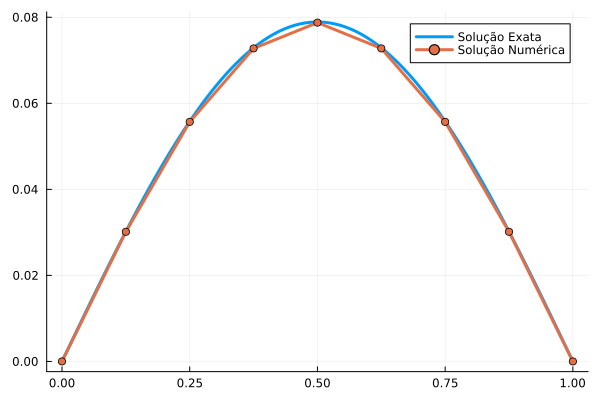

nothing

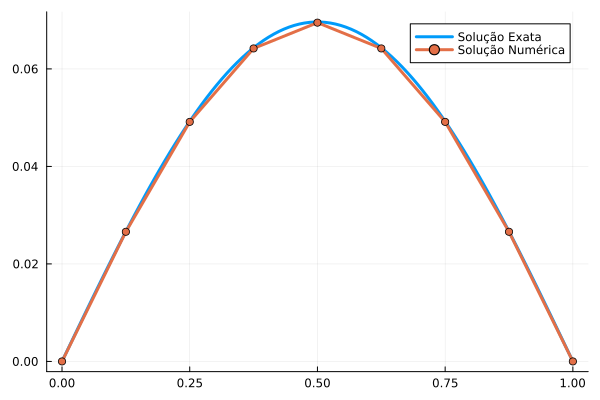

nothing

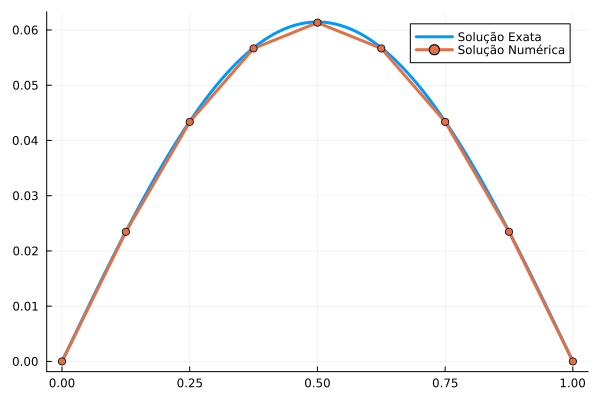

nothing

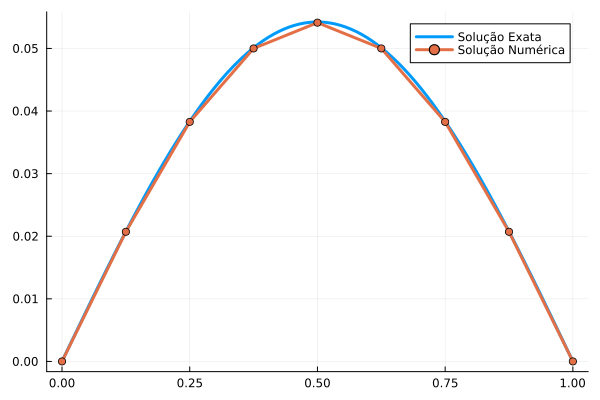

nothing

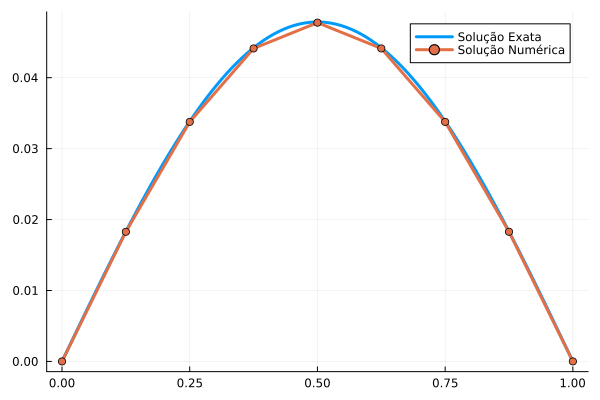

nothing

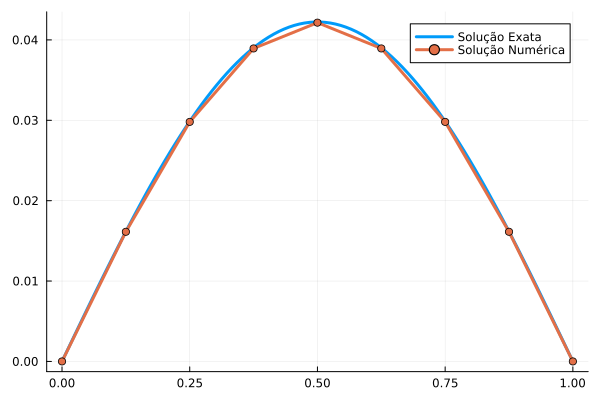

nothing

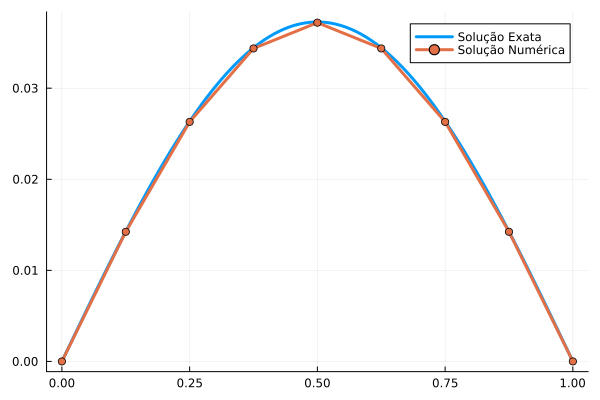

nothing

"Erros L2"

8-element Vector{Any}:
 0.0010051993482519549
 0.0008835570551819388
 0.0007830098844920445
 0.0006916106661135774
 0.0006104567407899794
 0.0005387470254921374
 0.00047544644369641097
 0.0004195807296660183

"Máximo erro L2"

0.0010051993482519549

In [29]:
u0(x) = sin(π*x)/π^2

α = 1.0
β = 1.0
γ = 0.0
T = 1
ne = 8

#Teste#

g(s) = 0
f_nao_linear = (x, t, α, β, γ) -> f2_parabolica(x, t, α, β)
u2_adaptada = (x, t, α, β, γ) -> u2_parabolica(x, t, α, β)

solucao_e_teste_parabolico_naolinear(α, β, γ, g, T, f_nao_linear, u2_adaptada, u0, 1, ne)

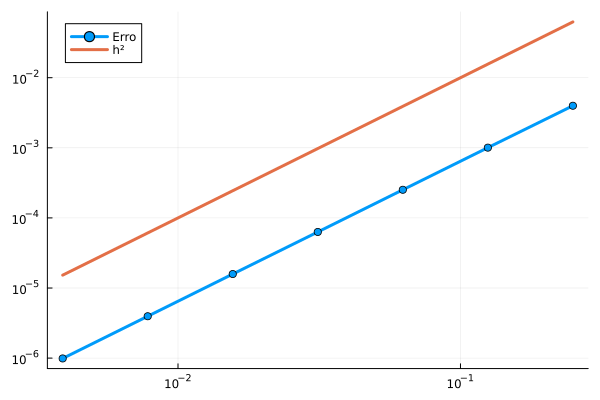

Row,h,erro
,Any,Any
1,0.25,0.00398034
2,0.125,0.0010052
3,0.0625,0.000251935
4,0.03125,6.30236e-5
5,0.015625,1.58247e-5
6,0.0078125,3.9563e-6
7,0.00390625,9.89128e-7


In [30]:
n_testes = 8
estudo_convergencia_parabolico_naolinear(α, β, γ, g, T, f_nao_linear, u2_adaptada, u0, n_testes)

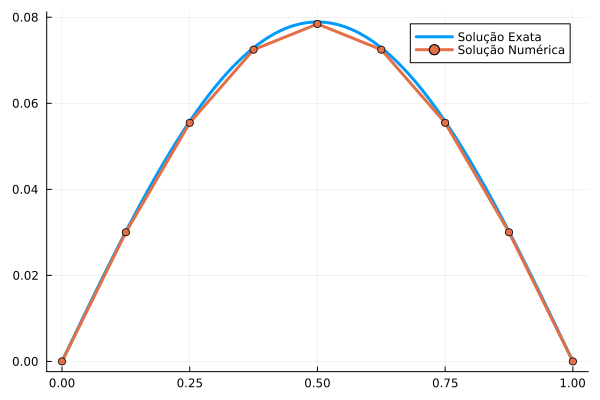

nothing

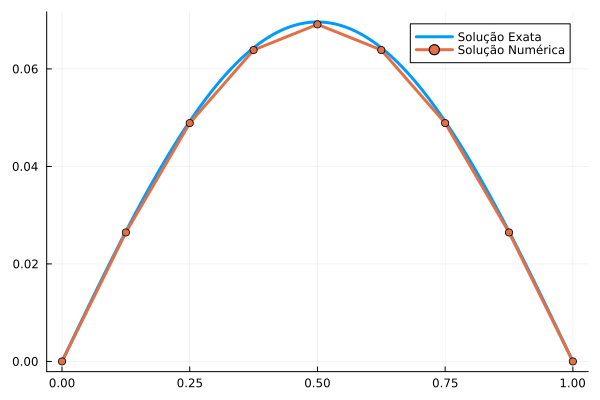

nothing

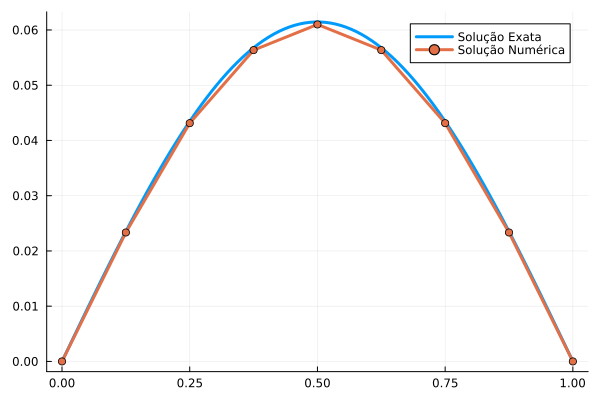

nothing

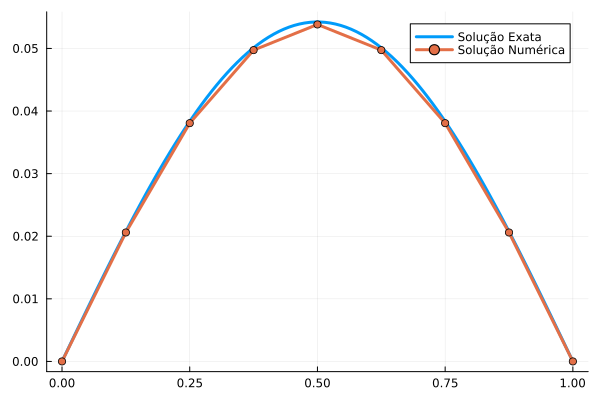

nothing

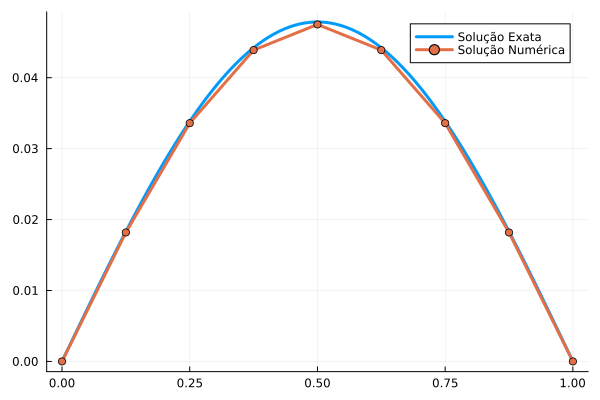

nothing

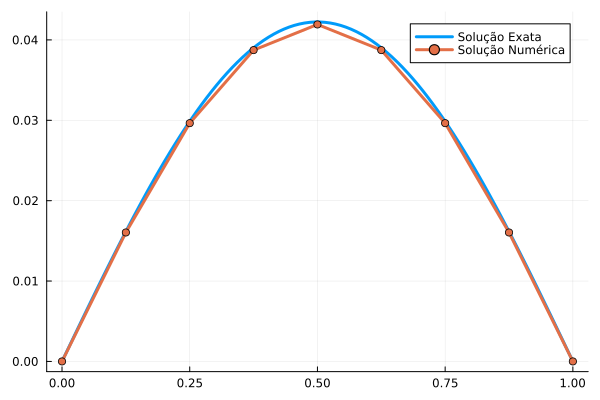

nothing

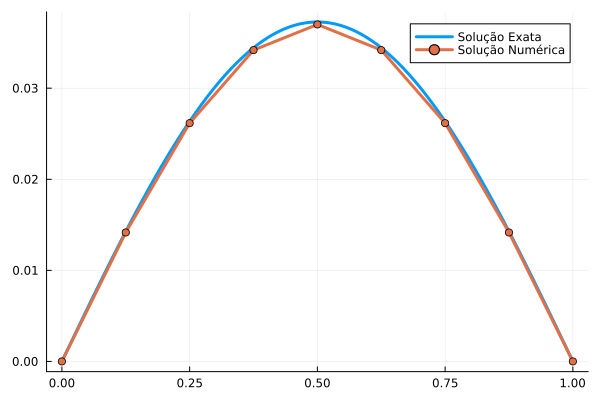

nothing

"Erros L2"

8-element Vector{Any}:
 0.0010051993482519549
 0.0010913589664605652
 0.0010171777834420443
 0.000907835087811311
 0.0008014608025943775
 0.0007067653743788086
 0.0006235586957198772
 0.0005503135195778129

"Máximo erro L2"

0.0010913589664605652

In [31]:
u0(x) = sin(π*x)/π^2
g(s) = s^3 - 2*s


α = 1.0
β = 1.0
γ = 0.0
T = 1
ne = 8

f_nao_linear = (x, t, α, β, γ) -> f2_parabolica_naolinear(x, t, α, β, γ, g, u2_parabolica_naolinear)
solucao_e_teste_parabolico_naolinear(α, β, γ, g, T, f_nao_linear, u2_parabolica_naolinear, u0, 1, ne)

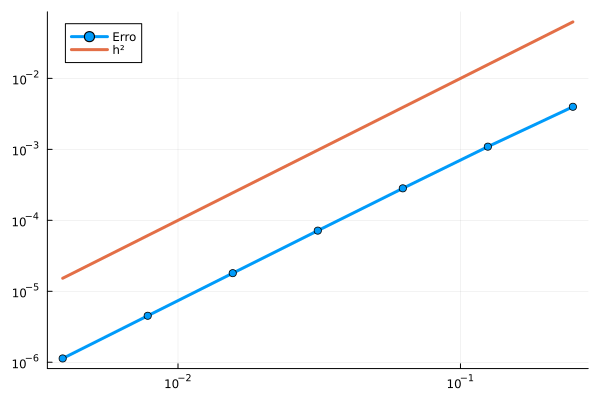

Row,h,erro
,Any,Any
1,0.25,0.00398034
2,0.125,0.00109136
3,0.0625,0.000282385
4,0.03125,7.15656e-5
5,0.015625,1.80095e-5
6,0.0078125,4.51901e-6
7,0.00390625,1.13185e-6


In [32]:
n_testes = 8
estudo_convergencia_parabolico_naolinear(α, β, γ, g, T, f_nao_linear, u2_parabolica_naolinear, u0, n_testes)